# Attack, Defense, and BPDA

In [ ]:
# Copyright (c) 2018-present, Royal Bank of Canada and other authors.
# See the AUTHORS.txt file for a list of contributors.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import argparse
import torch
import torch.nn as nn

from advertorch.utils import predict_from_logits
from advertorch_examples.utils import get_mnist_test_loader
from advertorch_examples.utils import _imshow

torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

### Load model that is trained with `tut_train_mnist.py`

In [2]:
from advertorch.test_utils import LeNet5
from advertorch_examples.utils import TRAINED_MODEL_PATH

filename = "mnist_lenet5_clntrained.pt"
# filename = "mnist_lenet5_advtrained.pt"

model = LeNet5()
model.load_state_dict(
    torch.load(os.path.join(TRAINED_MODEL_PATH, filename)))
model.to(device)
model.eval()

/home/gavin/anaconda3/envs/dev/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

### Load data

In [3]:
batch_size = 5
loader = get_mnist_test_loader(batch_size=batch_size)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

### Construct a LinfPGDAttack adversary instance

In [4]:
from advertorch.attacks import LinfPGDAttack

adversary = LinfPGDAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=40, eps_iter=0.01, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

### Perform untargeted attack

In [5]:
adv_untargeted = adversary.perturb(cln_data, true_label)

### Perform targeted attack

In [6]:
target = torch.ones_like(true_label) * 3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

### Visualization of attacks

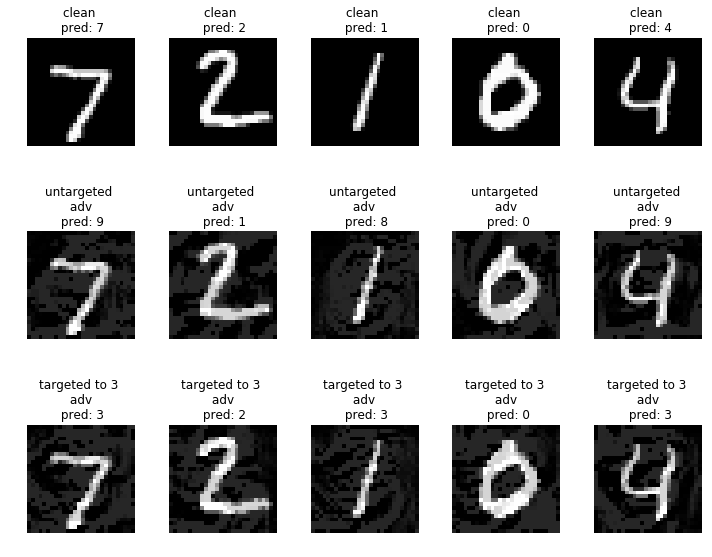

In [7]:
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted_adv = predict_from_logits(model(adv_untargeted))
pred_targeted_adv = predict_from_logits(model(adv_targeted))

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(
        pred_untargeted_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(
        pred_targeted_adv[ii]))

plt.tight_layout()
plt.show()

### Construct defenses based on preprocessing

In [8]:
from advertorch.defenses import MedianSmoothing2D
from advertorch.defenses import BitSqueezing
from advertorch.defenses import JPEGFilter

bits_squeezing = BitSqueezing(bit_depth=5)
median_filter = MedianSmoothing2D(kernel_size=3)
jpeg_filter = JPEGFilter(10)

defense = nn.Sequential(
    jpeg_filter,
    bits_squeezing,
    median_filter,
)

### Process the inputs using the defense
here we use the previous untargeted attack as the running example. 

In [9]:
adv = adv_untargeted
adv_defended = defense(adv)
cln_defended = defense(cln_data)

### Visualization of defenses

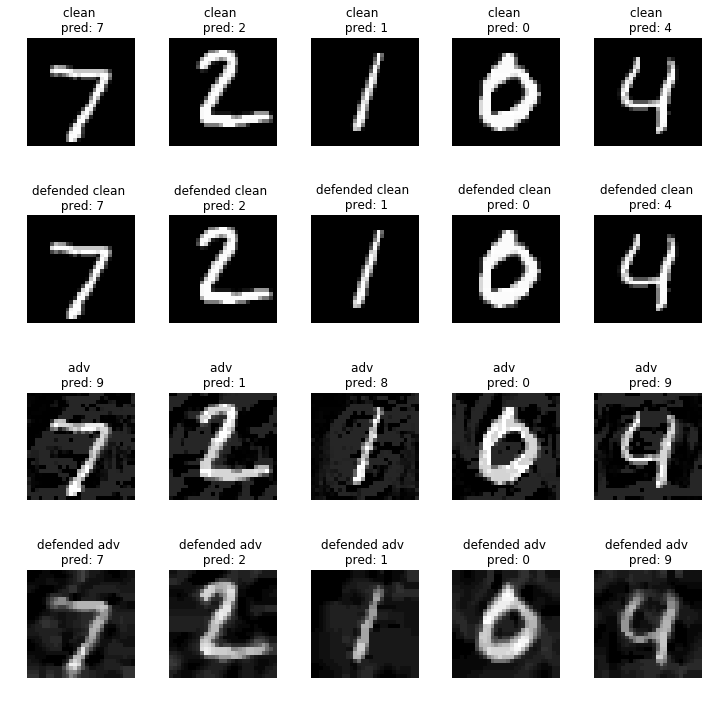

In [10]:
pred_cln = predict_from_logits(model(cln_data))
pred_cln_defended = predict_from_logits(model(cln_defended))
pred_adv = predict_from_logits(model(adv))
pred_adv_defended = predict_from_logits(model(adv_defended))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for ii in range(batch_size):
    plt.subplot(4, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size)
    _imshow(cln_data[ii])
    plt.title("defended clean \n pred: {}".format(pred_cln_defended[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size * 2)
    _imshow(adv[ii])
    plt.title("adv \n pred: {}".format(
        pred_adv[ii]))
    plt.subplot(4, batch_size, ii + 1 + batch_size * 3)
    _imshow(adv_defended[ii])
    plt.title("defended adv \n pred: {}".format(
        pred_adv_defended[ii]))

plt.tight_layout()
plt.show()

### BPDA (Backward Pass Differentiable Approximation)
BPDA is a method proposed in [1], which can be used to attack non-differentiable preprocessing based defenses. Here we use $f(x)$ to denote a non-differentiable component, and $g(x)$ to denote a differentiable component that is similar to $f(x)$. In BPDA, $f(x)$ is used in forward computation, and in the backward computation $g(x)$ is used to propagate down the gradients.

Here we use BPDA to perform adaptive attack towards the defenses we used above.

[1] Athalye, A., Carlini, N. & Wagner, D.. (2018). Obfuscated Gradients Give a False Sense of Security: Circumventing Defenses to Adversarial Examples. Proceedings of the 35th International Conference on Machine Learning, in PMLR 80:274-283

In [11]:
from advertorch.bpda import BPDAWrapper
defense_withbpda = BPDAWrapper(defense, forwardsub=lambda x: x)
defended_model = nn.Sequential(defense_withbpda, model)
bpda_adversary = LinfPGDAttack(
    defended_model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15,
    nb_iter=1000, eps_iter=0.005, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)


bpda_adv = bpda_adversary.perturb(cln_data, true_label)
bpda_adv_defended = defense(bpda_adv)

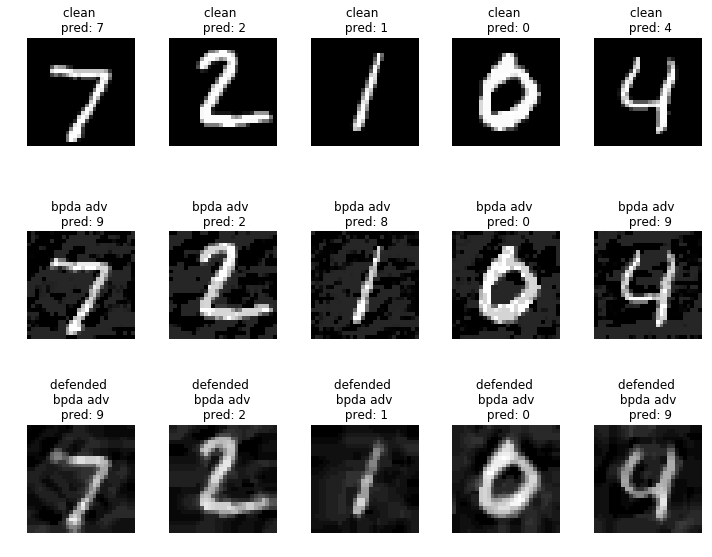

In [12]:
pred_cln = predict_from_logits(model(cln_data))
pred_bpda_adv = predict_from_logits(model(bpda_adv))
pred_bpda_adv_defended = predict_from_logits(model(bpda_adv_defended))


import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
for ii in range(batch_size):
    plt.subplot(3, batch_size, ii + 1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size)
    _imshow(bpda_adv[ii])
    plt.title("bpda adv \n pred: {}".format(
        pred_bpda_adv[ii]))
    plt.subplot(3, batch_size, ii + 1 + batch_size * 2)
    _imshow(bpda_adv_defended[ii])
    plt.title("defended \n bpda adv \n pred: {}".format(
        pred_bpda_adv_defended[ii]))

plt.tight_layout()
plt.show()
